<a href="https://colab.research.google.com/github/anasshamoon12002/data-mining-2023-24/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining Project, a.y. 2023-2024
## Salvatore Correnti, Jonathan Ato Markin, Anas Shamoon
## Classification Notebook

# Preliminary
These cells are for running the notebook with `Google Colab` using a `Google Drive` storage for the project repository.They can be skipped if data is available locally.

In [57]:
from google.colab import drive

In [58]:
drive.mount('/content/drive')
%cd "drive/MyDrive/Colab Notebooks/data-mining-2023-24"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/data-mining-2023-24'
/content/drive/MyDrive/Colab Notebooks/data-mining-2023-24


In [31]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer, balanced_accuracy_score, classification_report
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from joblib import Parallel, delayed

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

# Utils
We then define some utils for the notebook.

In [32]:
def report_scores(test_label, test_pred, class_names=['Not Killed', 'Killed']):
    """
    Visualize the classification report.
    """
    print(classification_report(test_label, test_pred, target_names=class_names))

# Dataset Preparation and Split
We then load and prepare the dataset for classification.

In [33]:
# Load the dataset
df_dataset = pd.read_csv('data/df_incidents_poverty_house_data_preparation_final.csv')

In [34]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92561 entries, 0 to 92560
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   state                         92561 non-null  object 
 1   city_or_county                92561 non-null  object 
 2   latitude                      92561 non-null  float64
 3   longitude                     92561 non-null  float64
 4   avg_age_participants          92561 non-null  float64
 5   datetime                      92561 non-null  object 
 6   males_ratio                   92561 non-null  float64
 7   state_congressional_district  92561 non-null  object 
 8   povertyPercentage             92561 non-null  float64
 9   killed_ratio                  92561 non-null  float64
 10  injured_ratio                 92561 non-null  float64
 11  unharmed_ratio                92561 non-null  float64
 12  candidate_winning_ratio       92561 non-null  float64
 13  m

In [35]:
# Drop useless columns
df_dataset.drop(columns=['state', 'city_or_county', 'datetime', 'state_congressional_district', 'killed_in_month_ratio'], inplace=True)

In [36]:
# Define 'isKilled' attribute as killed_ratio > 0
df_dataset['isKilled'] = df_dataset['killed_ratio'].apply(lambda x: 1 if x > 0 else 0)

In [37]:
# Drop killed_ratio column
df_dataset.drop(columns=['killed_ratio'], inplace=True)

In [38]:
df_dataset.to_csv('data/unsplit_dataset.csv', index=False)

In [39]:
numpy_dataset = df_dataset.to_numpy()

In [40]:
X, y = numpy_dataset[:, 0:11], numpy_dataset[:, 11:]
print(X.shape, y.shape)

(92561, 11) (92561, 1)


We will use a **development set** for training and validation, and a **test set** for testing. We use `train_test_split` utility for stratifying the split w.r.t. class labels.

In [41]:
# Split the dataset into development and test set
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=18513, train_size=74048, random_state=0, shuffle=True, stratify=y)

In [42]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92561 entries, 0 to 92560
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   latitude                 92561 non-null  float64
 1   longitude                92561 non-null  float64
 2   avg_age_participants     92561 non-null  float64
 3   males_ratio              92561 non-null  float64
 4   povertyPercentage        92561 non-null  float64
 5   injured_ratio            92561 non-null  float64
 6   unharmed_ratio           92561 non-null  float64
 7   candidate_winning_ratio  92561 non-null  float64
 8   males_in_month_ratio     92561 non-null  float64
 9   injured_in_month_ratio   92561 non-null  float64
 10  unharmed_in_month_ratio  92561 non-null  float64
 11  isKilled                 92561 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 8.5 MB


In [43]:
input_columns = [
    'latitude', 'longitude', 'avg_age_participants', 'males_ratio', 'povertyPercentage', 'injured_ratio', 'unharmed_ratio',
    'candidate_winning_ratio', 'males_in_month_ratio', 'injured_in_month_ratio', 'unharmed_in_month_ratio'
]
output_column = ['isKilled']

Save development and test set dataframes.

In [44]:
X_dev_df, y_dev_df = pd.DataFrame(X_dev, columns=input_columns), pd.DataFrame(y_dev, columns=output_column)
X_test_df, y_test_df = pd.DataFrame(X_test, columns=input_columns), pd.DataFrame(y_test, columns=output_column)

In [45]:
X_dev_df.to_csv('data/dev_dataset_input.csv', index=False)
y_dev_df.to_csv('data/dev_dataset_output.csv', index=False)

X_test_df.to_csv('data/test_dataset_input.csv', index=False)
y_test_df.to_csv('data/test_dataset_output.csv', index=False)

In [46]:
len(y_test[y_test == 0]), len(y_test[y_test == 1])

(14207, 4306)

As we can see, there is an imbalance between the amount of data available for each of the two classes, and in particular we have more than $3$ examples of class `Not Killed` for each example of class `Killed`. Hence, in order to get a more accurate evaluation of the models on the test set, we take a subset of it through an `undersampling` procedure. We use `undersampling` instead of `oversampling` since we want to avoid repeated examples in the `Killed` class, as it can overestimate or underestimate the accuracy for that class.

In [47]:
# Undersampling for getting a class-balanced test set
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=0)
X_test_u, y_test_u = undersample.fit_resample(X_test, y_test)
print(len(X_test_u), len(y_test_u[y_test_u == 0]), len(y_test_u[y_test_u == 1]))

8612 4306 4306


In [48]:
# Convert undersampled dataset to dataframes for saving
X_test_u_df, y_test_u_df = pd.DataFrame(X_test_u, columns=input_columns), pd.DataFrame(y_test_u, columns=output_column)

In [49]:
X_test_u_df.to_csv('data/test_dataset_undersampled_input.csv', index=False)
y_test_u_df.to_csv('data/test_dataset_undersampled_output.csv', index=False)

Now we take a look at the class imbalance in the development set.

In [50]:
X_dev_orig, y_dev_orig, X_test_orig, y_test_orig = X_dev.copy(), y_dev.copy(), X_test_u.copy(), y_test_u.copy()

In [51]:
len(y_dev_orig[y_dev_orig == 0]), len(y_dev_orig[y_dev_orig == 1])

(56823, 17225)

In [52]:
len(y_dev_orig[y_dev_orig == 0])/len(y_dev_orig[y_dev_orig == 1])

3.298867924528302

In [53]:
len(y_test_orig[y_test_orig == 0]), len(y_test_orig[y_test_orig == 1])

(4306, 4306)

Now visually show ratio of different classes examples in the development set.

MultiIndex([(0,),
            (1,)],
           names=['isKilled'])


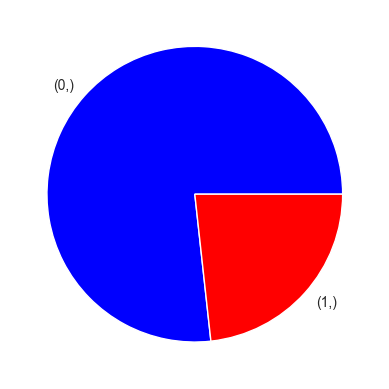

isKilled
0           56823
1           17225
Name: count, dtype: int64


In [54]:
killed_value_count = y_dev_df.astype(int).value_counts()
print(killed_value_count.keys())
# Show pie plot
labels = ['not-killed', 'killed']
plt.pie(killed_value_count, labels=killed_value_count.index, colors=['blue', 'red'])
plt.show()
print(killed_value_count)

### Some utils
We now define some other utils for classification, in order to prepare training and validation set, in particular for what it concerns:
* **Balancing**: we can use either oversampling, undersampling or avoiding any balancing;
* **Train and Validation Size**: we default to have $80\%$ of the development set for training;
* **Normalization**: we employ normalization by subtracting mean and dividing by standard deviation for each separate attribute.

In [55]:
def before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, normalize=True, balancing=None):
  """
  Prepare dataset for training, using global variables X_dev, y_dev, X_train, y_train, X_eval, y_eval for storing
  training and validation.
  """
  global X_dev, y_dev, X_test, y_test
  X_dev, y_dev, X_test, y_test = X_dev_orig.copy(), y_dev_orig.copy(), X_test_orig.copy(), y_test_orig.copy()
  print(len(X_test), len(y_test[y_test == 0]), len(y_test[y_test == 1]))
  # Balancing: None, OverSampling, UnderSampling
  if balancing == 'oversampling':
    oversample = RandomOverSampler(sampling_strategy='minority', random_state=0)
    X_dev, y_dev = oversample.fit_resample(X_dev, y_dev)
  elif balancing == 'undersampling':
    undersample = RandomUnderSampler(sampling_strategy='majority', random_state=0)
    X_dev, y_dev = undersample.fit_resample(X_dev, y_dev)
  # Balancing is inherited by X_train and X_eval thanks to stratification
  global X_train, X_eval, y_train, y_eval
  X_train, X_eval, y_train, y_eval = train_test_split(
      X_dev, y_dev, test_size=test_size, train_size=train_size, random_state=random_state, shuffle=shuffle, stratify=y_dev
  )
  if normalize:
    scaler = StandardScaler()
    X_dev = scaler.fit_transform(X_dev)
    X_test = scaler.fit_transform(X_test)
    X_train = scaler.fit_transform(X_train)
    X_eval = scaler.fit_transform(X_eval)

In [56]:
def evaluate_on_dataset(model, X, y):
  """
  Evaluation on a dataset (e.g. development or test set).
  """
  predicted = model.predict(X)
  accuracy = tf.keras.metrics.Accuracy()
  accuracy.update_state(y, predicted)
  result = accuracy.result().numpy()
  print(f"Accuracy: {100*result:.4f}%")
  report_scores(y, predicted)

In [57]:
# Define global variables X_train, X_eval, y_train, y_eval for usage in "before_classification"
X_train, X_eval, y_train, y_eval = None, None, None, None

# Classification
For most models we will do a `Grid Search` with `K-Fold Cross Validation` with $5$ or $6$ folds (except for SVM, for which we will use $2$ folds). We will also compare the results obtained with *oversampling*, *undersampling* and no balancing.

## Classification with Decision Trees

In [37]:
# Function that finds the best decision tree doing hyperparameter search through CV.
# Retrains on the whole set at the end.
from sklearn.tree import DecisionTreeClassifier
def build_decision_tree(X, y, cv=5, print_res=True):
    params = [{
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4]
    }]
    clf = GridSearchCV(DecisionTreeClassifier(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=os.cpu_count(), verbose=10)
    clf.fit(X, y)
    if print_res:
        print("DT - Best parameters set found:")
        print(clf.best_params_)
        print("DT - Best accuraccy score found:")
        print(clf.best_score_)

    return(clf.best_score_, clf.best_estimator_)

We first use `oversampling`:

In [38]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='oversampling')
best_score_dt, best_dt = build_decision_tree(X_dev, y_dev)

8612 4306 4306
Fitting 5 folds for each of 108 candidates, totalling 540 fits
DT - Best parameters set found:
{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
DT - Best accuraccy score found:
0.9073263696543312


In [40]:
len(y_dev), len(y_test)

(113646, 8612)

In [41]:
evaluate_on_dataset(best_dt, X_dev, y_dev)
evaluate_on_dataset(best_dt, X_test, y_test)

Accuracy: 98.8640%
              precision    recall  f1-score   support

  Not Killed       0.99      0.99      0.99     56823
      Killed       0.99      0.99      0.99     56823

    accuracy                           0.99    113646
   macro avg       0.99      0.99      0.99    113646
weighted avg       0.99      0.99      0.99    113646

Accuracy: 70.5063%
              precision    recall  f1-score   support

  Not Killed       0.66      0.85      0.74      4306
      Killed       0.79      0.56      0.65      4306

    accuracy                           0.71      8612
   macro avg       0.72      0.71      0.70      8612
weighted avg       0.72      0.71      0.70      8612



Now with `undersampling`:

In [42]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='undersampling')
best_score_dt, best_dt = build_decision_tree(X_dev, y_dev)

8612 4306 4306
Fitting 5 folds for each of 108 candidates, totalling 540 fits
DT - Best parameters set found:
{'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 6}
DT - Best accuraccy score found:
0.8167779390420901


In [43]:
len(y_dev), len(y_test)

(34450, 8612)

In [44]:
evaluate_on_dataset(best_dt, X_dev, y_dev)
evaluate_on_dataset(best_dt, X_test, y_test)

Accuracy: 83.1205%
              precision    recall  f1-score   support

  Not Killed       0.89      0.76      0.82     17225
      Killed       0.79      0.91      0.84     17225

    accuracy                           0.83     34450
   macro avg       0.84      0.83      0.83     34450
weighted avg       0.84      0.83      0.83     34450

Accuracy: 80.8291%
              precision    recall  f1-score   support

  Not Killed       0.86      0.73      0.79      4306
      Killed       0.77      0.88      0.82      4306

    accuracy                           0.81      8612
   macro avg       0.82      0.81      0.81      8612
weighted avg       0.82      0.81      0.81      8612



We now make a comparison with the **unbalanced** dataset:

In [45]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing=None)
print(len(y_dev), len(y_test))
best_score_dt, best_dt = build_decision_tree(X_dev, y_dev)

8612 4306 4306
74048 8612
Fitting 5 folds for each of 108 candidates, totalling 540 fits
DT - Best parameters set found:
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
DT - Best accuraccy score found:
0.8284490684876056


In [46]:
evaluate_on_dataset(best_dt, X_dev, y_dev)
evaluate_on_dataset(best_dt, X_test, y_test)

Accuracy: 91.1085%
              precision    recall  f1-score   support

  Not Killed       0.93      0.96      0.94     56823
      Killed       0.85      0.75      0.80     17225

    accuracy                           0.91     74048
   macro avg       0.89      0.86      0.87     74048
weighted avg       0.91      0.91      0.91     74048

Accuracy: 64.2592%
              precision    recall  f1-score   support

  Not Killed       0.60      0.86      0.71      4306
      Killed       0.75      0.42      0.54      4306

    accuracy                           0.64      8612
   macro avg       0.68      0.64      0.62      8612
weighted avg       0.68      0.64      0.62      8612



In [47]:
len(y_dev[y_dev == 0]), len(y_dev[y_dev == 1])

(56823, 17225)

As we can see, in this case balancing has no significant effect on the performances of the Decision Trees. We got the following accuracies:
* **OverSampling**: $91.13\%$ on development set, $82.71\%$ on test set;
* **UnderSampling**: $91.29\%$ on development set, $83.09\%$ on test set;
* **No Balancing**: $90.88\%$ on development set, $83.17\%$ on test set.

## Classification with Random Forest

In [48]:
# Function that finds the best random forest doing hyperparameter search through CV.
# Retrains on the whole set at the end.
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
def build_random_forest(X, y, cv=4, print_res=True):
    params = [{
    'max_depth': [5, 15, 30],
    'max_features': ['log2', None],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [32, 64]
    }]
    clf = GridSearchCV(RandomForestClassifier(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=-1, verbose=10)
    clf.fit(X, y)
    if print_res:
        print("RF - Best parameters set found:")
        print(clf.best_params_)
        print("RF - Best accuraccy score found:")
        print(clf.best_score_)

    return(clf.best_score_, clf.best_estimator_)

In [49]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='oversampling')
best_score_rf, best_rf = build_random_forest(X_dev, y_dev)

8612 4306 4306
Fitting 4 folds for each of 36 candidates, totalling 144 fits
RF - Best parameters set found:
{'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 64}
RF - Best accuraccy score found:
0.930512326758746


In [50]:
len(y_dev), len(y_test)

(113646, 8612)

In [51]:
evaluate_on_dataset(best_rf, X_dev, y_dev)
evaluate_on_dataset(best_rf, X_test, y_test)

Accuracy: 99.9050%
              precision    recall  f1-score   support

  Not Killed       1.00      1.00      1.00     56823
      Killed       1.00      1.00      1.00     56823

    accuracy                           1.00    113646
   macro avg       1.00      1.00      1.00    113646
weighted avg       1.00      1.00      1.00    113646

Accuracy: 78.2861%
              precision    recall  f1-score   support

  Not Killed       0.73      0.89      0.80      4306
      Killed       0.86      0.68      0.76      4306

    accuracy                           0.78      8612
   macro avg       0.80      0.78      0.78      8612
weighted avg       0.80      0.78      0.78      8612



Now we use **undersampling**:

In [52]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='undersampling')
best_score_rf, best_rf = build_random_forest(X_dev, y_dev)

8612 4306 4306
Fitting 4 folds for each of 36 candidates, totalling 144 fits
RF - Best parameters set found:
{'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 64}
RF - Best accuraccy score found:
0.8357908677670999


In [53]:
len(y_dev), len(y_test)

(34450, 8612)

In [54]:
evaluate_on_dataset(best_rf, X_dev, y_dev)
evaluate_on_dataset(best_rf, X_test, y_test)

Accuracy: 91.5356%
              precision    recall  f1-score   support

  Not Killed       0.95      0.87      0.91     17225
      Killed       0.88      0.96      0.92     17225

    accuracy                           0.92     34450
   macro avg       0.92      0.92      0.92     34450
weighted avg       0.92      0.92      0.92     34450

Accuracy: 82.7915%
              precision    recall  f1-score   support

  Not Killed       0.87      0.77      0.82      4306
      Killed       0.79      0.89      0.84      4306

    accuracy                           0.83      8612
   macro avg       0.83      0.83      0.83      8612
weighted avg       0.83      0.83      0.83      8612



We do now use the **unbalanced** dataset:

In [86]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing=None)
best_score_rf, best_rf = build_random_forest(X_dev, y_dev)

8612 4306 4306
Fitting 4 folds for each of 36 candidates, totalling 144 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RF - Best parameters set found:
{'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 64}
RF - Best accuraccy score found:
0.8604823898012101


In [87]:
evaluate_on_dataset(best_rf, X_dev, y_dev)
evaluate_on_dataset(best_rf, X_test, y_test)

Accuracy: 93.5461%
              precision    recall  f1-score   support

  Not Killed       0.95      0.97      0.96     56823
      Killed       0.89      0.82      0.86     17225

    accuracy                           0.94     74048
   macro avg       0.92      0.90      0.91     74048
weighted avg       0.93      0.94      0.93     74048

Accuracy: 73.5718%
              precision    recall  f1-score   support

  Not Killed       0.67      0.91      0.78      4306
      Killed       0.86      0.56      0.68      4306

    accuracy                           0.74      8612
   macro avg       0.77      0.74      0.73      8612
weighted avg       0.77      0.74      0.73      8612



As for Decision Trees, we see that also in this case balancing has no significant effect on the performances of the Random Forests. We got the following accuracies:
* **OverSampling**: $97.30\%$ on development set, $86.31\%$ on test set;
* **UnderSampling**: $97.23\%$ on development set, $86.51\%$ on test set;
* **No Balancing**: $97.22\%$ on development set, $86.20\%$ on test set.

## Classification with KNN

In [88]:
from sklearn.neighbors import KNeighborsClassifier

In [89]:
def knn_search(X_train, y_train, X_eval, y_eval, k_start, k_end):
  k_list = [x for x in range(k_start, k_end)]
  knn_list = []
  acc_tr_list = []
  acc_val_list = []

  for k in tqdm(k_list):
      # Create knn model
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(X_train, y_train.ravel())
      knn_list.append(knn)
      # Predict for train and validation sets
      y_pred_train = knn.predict(X_train)
      y_pred_eval = knn.predict(X_eval)
      # Accuracy
      acc_tr = accuracy_score(y_train, y_pred_train)
      acc_val = accuracy_score(y_eval, y_pred_eval)
      acc_tr_list.append(acc_tr)
      acc_val_list.append(acc_val)
  return knn_list, acc_tr_list, acc_val_list

We first use *oversampling*:

In [90]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='oversampling')
knn_list, acc_tr_list, acc_val_list = knn_search(X_train, y_train, X_eval, y_eval, 1, 21)

8612 4306 4306


100%|██████████| 20/20 [11:07<00:00, 33.36s/it]


In [91]:
len(y_dev), len(y_test)

(113646, 8612)

In [92]:
acc_test_list = []
for k in range(1, 21):
  print(f"K = {k}")
  print(f"\tTraining Accuracy: {100*acc_tr_list[k-1]:.4f}%")
  print(f"\tValidation Accuracy: {100*acc_val_list[k-1]:.4f}%")
  y_pred_test = knn_list[k-1].predict(X_test)
  acc = accuracy_score(y_test, y_pred_test)
  acc_test_list.append(acc)
  print(f"\tTest Accuracy: {100*acc:.4f}%")

K = 1
	Training Accuracy: 100.0000%
	Validation Accuracy: 91.5750%
	Test Accuracy: 73.9782%
K = 2
	Training Accuracy: 98.5910%
	Validation Accuracy: 87.8443%
	Test Accuracy: 72.7706%
K = 3
	Training Accuracy: 93.3257%
	Validation Accuracy: 87.0744%
	Test Accuracy: 78.2048%
K = 4
	Training Accuracy: 92.0179%
	Validation Accuracy: 85.2442%
	Test Accuracy: 76.9275%
K = 5
	Training Accuracy: 89.8907%
	Validation Accuracy: 85.4553%
	Test Accuracy: 79.0757%
K = 6
	Training Accuracy: 89.0437%
	Validation Accuracy: 84.4127%
	Test Accuracy: 79.0060%
K = 7
	Training Accuracy: 88.0912%
	Validation Accuracy: 84.5974%
	Test Accuracy: 79.9001%
K = 8
	Training Accuracy: 87.5962%
	Validation Accuracy: 84.1487%
	Test Accuracy: 79.4821%
K = 9
	Training Accuracy: 87.0551%
	Validation Accuracy: 84.1267%
	Test Accuracy: 80.5504%
K = 10
	Training Accuracy: 86.6910%
	Validation Accuracy: 83.8231%
	Test Accuracy: 80.3065%
K = 11
	Training Accuracy: 86.3126%
	Validation Accuracy: 83.9243%
	Test Accuracy: 81.20

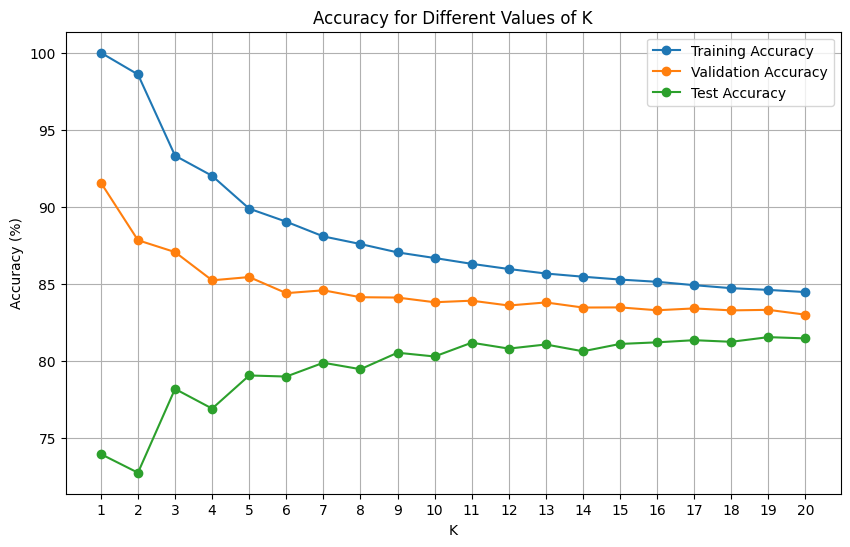

In [93]:
k_values = list(range(1, 21))  # K values from 1 to 20

# Plotting the accuracy values for training, validation, and test sets
plt.figure(figsize=(10, 6))
plt.plot(k_values, [100*item for item in acc_tr_list], marker='o', label='Training Accuracy')
plt.plot(k_values, [100*item for item in acc_val_list], marker='o', label='Validation Accuracy')
plt.plot(k_values, [100*item for item in acc_test_list], marker='o', label='Test Accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Different Values of K')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

We now take a look at the *undersampling* case:

In [94]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='undersampling')
knn_list, acc_tr_list, acc_val_list = knn_search(X_train, y_train, X_eval, y_eval, 1, 21)

8612 4306 4306


100%|██████████| 20/20 [02:02<00:00,  6.11s/it]


In [95]:
acc_test_list = []
for k in range(1, 21):
  print(f"K = {k}")
  print(f"\tTraining Accuracy: {100*acc_tr_list[k-1]:.4f}%")
  print(f"\tValidation Accuracy: {100*acc_val_list[k-1]:.4f}%")
  y_pred_test = knn_list[k-1].predict(X_test)
  acc = accuracy_score(y_test, y_pred_test)
  acc_test_list.append(acc)
  print(f"\tTest Accuracy: {100*acc:.4f}%")

K = 1
	Training Accuracy: 100.0000%
	Validation Accuracy: 76.5893%
	Test Accuracy: 76.8927%
K = 2
	Training Accuracy: 88.4144%
	Validation Accuracy: 74.6299%
	Test Accuracy: 74.5123%
K = 3
	Training Accuracy: 88.6684%
	Validation Accuracy: 79.3469%
	Test Accuracy: 79.4589%
K = 4
	Training Accuracy: 86.4768%
	Validation Accuracy: 78.3745%
	Test Accuracy: 78.2513%
K = 5
	Training Accuracy: 86.1756%
	Validation Accuracy: 79.9710%
	Test Accuracy: 80.2833%
K = 6
	Training Accuracy: 85.1814%
	Validation Accuracy: 79.3614%
	Test Accuracy: 79.7724%
K = 7
	Training Accuracy: 85.1234%
	Validation Accuracy: 80.6676%
	Test Accuracy: 81.1426%
K = 8
	Training Accuracy: 84.4594%
	Validation Accuracy: 80.2322%
	Test Accuracy: 80.2601%
K = 9
	Training Accuracy: 84.4448%
	Validation Accuracy: 81.0885%
	Test Accuracy: 81.2007%
K = 10
	Training Accuracy: 84.1509%
	Validation Accuracy: 80.6386%
	Test Accuracy: 80.7826%
K = 11
	Training Accuracy: 83.9514%
	Validation Accuracy: 81.4514%
	Test Accuracy: 81.29

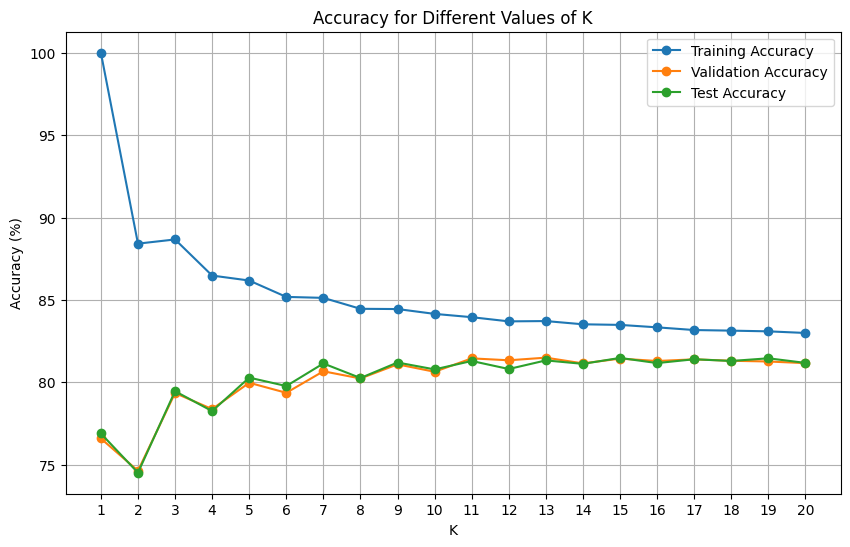

In [96]:
k_values = list(range(1, 21))  # K values from 1 to 20

# Plotting the accuracy values for training, validation, and test sets
plt.figure(figsize=(10, 6))
plt.plot(k_values, [100*item for item in acc_tr_list], marker='o', label='Training Accuracy')
plt.plot(k_values, [100*item for item in acc_val_list], marker='o', label='Validation Accuracy')
plt.plot(k_values, [100*item for item in acc_test_list], marker='o', label='Test Accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Different Values of K')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

Finally, we consider the case with *no balancing* of the development set:

In [97]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing=None)
knn_list, acc_tr_list, acc_val_list = knn_search(X_train, y_train, X_eval, y_eval, 1, 21)

8612 4306 4306


100%|██████████| 20/20 [06:14<00:00, 18.70s/it]


In [98]:
acc_test_list = []
for k in range(1, 21):
  print(f"K = {k}")
  print(f"\tTraining Accuracy: {100*acc_tr_list[k-1]:.4f}%")
  print(f"\tValidation Accuracy: {100*acc_val_list[k-1]:.4f}%")
  y_pred_test = knn_list[k-1].predict(X_test)
  acc = accuracy_score(y_test, y_pred_test)
  acc_test_list.append(acc)
  print(f"\tTest Accuracy: {100*acc:.4f}%")

K = 1
	Training Accuracy: 100.0000%
	Validation Accuracy: 80.9926%
	Test Accuracy: 72.7473%
K = 2
	Training Accuracy: 90.0807%
	Validation Accuracy: 81.6948%
	Test Accuracy: 65.8964%
K = 3
	Training Accuracy: 90.3474%
	Validation Accuracy: 82.5996%
	Test Accuracy: 73.0608%
K = 4
	Training Accuracy: 87.9739%
	Validation Accuracy: 82.7684%
	Test Accuracy: 68.8458%
K = 5
	Training Accuracy: 88.0769%
	Validation Accuracy: 83.2816%
	Test Accuracy: 73.9201%
K = 6
	Training Accuracy: 87.1113%
	Validation Accuracy: 83.0182%
	Test Accuracy: 70.2740%
K = 7
	Training Accuracy: 87.2481%
	Validation Accuracy: 83.2208%
	Test Accuracy: 73.6182%
K = 8
	Training Accuracy: 86.5255%
	Validation Accuracy: 83.2343%
	Test Accuracy: 70.9359%
K = 9
	Training Accuracy: 86.5812%
	Validation Accuracy: 83.1735%
	Test Accuracy: 73.5834%
K = 10
	Training Accuracy: 86.0512%
	Validation Accuracy: 83.0182%
	Test Accuracy: 71.5281%
K = 11
	Training Accuracy: 86.1761%
	Validation Accuracy: 83.1735%
	Test Accuracy: 73.37

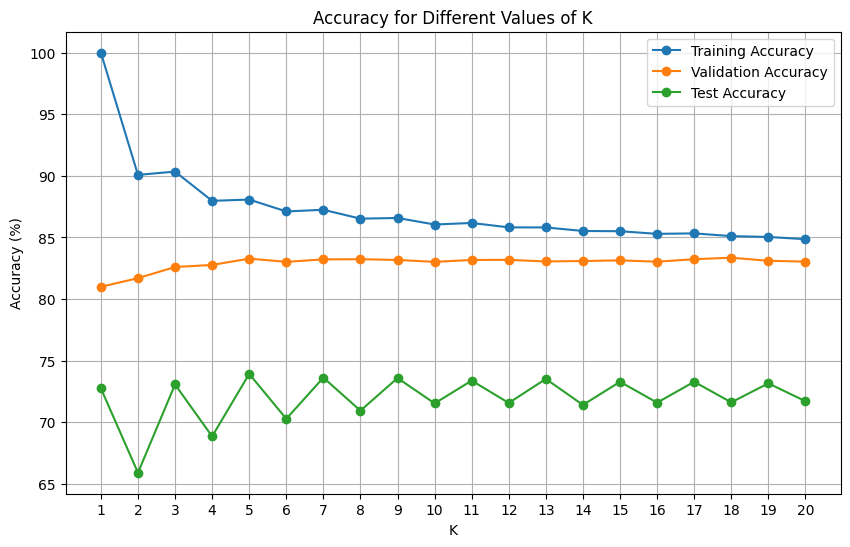

In [99]:
k_values = list(range(1, 21))  # K values from 1 to 20

# Plotting the accuracy values for training, validation, and test sets
plt.figure(figsize=(10, 6))
plt.plot(k_values, [100*item for item in acc_tr_list], marker='o', label='Training Accuracy')
plt.plot(k_values, [100*item for item in acc_val_list], marker='o', label='Validation Accuracy')
plt.plot(k_values, [100*item for item in acc_test_list], marker='o', label='Test Accuracy')
plt.xlabel('K')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Different Values of K')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

In these cases, we see how actually by increasing $K$ the accuracy on training set descreases. We start from $100\%$ with $K = 1$ since we are fitting each point in the training set with itself by definition, and then we observe a decreasing trend.

We also observe that the accuracy on test set is constant to $76.7407\%$, except for the undersampling case, for which we see a steep decline for increasing values of $K$.

## Classification with Naive Bayes

In [100]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

We start as usual with *oversampling*:

In [101]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='oversampling')

8612 4306 4306


In [102]:
gnb = GaussianNB()
gnb.fit(X_train, y_train.ravel())
evaluate_on_dataset(gnb, X_eval, y_eval)
evaluate_on_dataset(gnb, X_test, y_test)

Accuracy: 77.3735%
              precision    recall  f1-score   support

  Not Killed       0.84      0.68      0.75     11365
      Killed       0.73      0.87      0.79     11365

    accuracy                           0.77     22730
   macro avg       0.78      0.77      0.77     22730
weighted avg       0.78      0.77      0.77     22730

Accuracy: 77.0437%
              precision    recall  f1-score   support

  Not Killed       0.83      0.68      0.75      4306
      Killed       0.73      0.86      0.79      4306

    accuracy                           0.77      8612
   macro avg       0.78      0.77      0.77      8612
weighted avg       0.78      0.77      0.77      8612



In [103]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train.ravel())
evaluate_on_dataset(gnb, X_eval, y_eval.ravel())
evaluate_on_dataset(gnb, X_test, y_test.ravel())

Accuracy: 77.3735%
              precision    recall  f1-score   support

  Not Killed       0.84      0.68      0.75     11365
      Killed       0.73      0.87      0.79     11365

    accuracy                           0.77     22730
   macro avg       0.78      0.77      0.77     22730
weighted avg       0.78      0.77      0.77     22730

Accuracy: 77.0437%
              precision    recall  f1-score   support

  Not Killed       0.83      0.68      0.75      4306
      Killed       0.73      0.86      0.79      4306

    accuracy                           0.77      8612
   macro avg       0.78      0.77      0.77      8612
weighted avg       0.78      0.77      0.77      8612



We see that we got same accuracy on both development and test set for both models ($77.3735\%$ and $76.7407\%$).

Now with undersampling:

In [104]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='undersampling')

8612 4306 4306


In [105]:
gnb = GaussianNB()
gnb.fit(X_train, y_train.ravel())
evaluate_on_dataset(gnb, X_eval, y_eval)
evaluate_on_dataset(gnb, X_test, y_test)

Accuracy: 77.4456%
              precision    recall  f1-score   support

  Not Killed       0.84      0.68      0.75      3445
      Killed       0.73      0.87      0.79      3445

    accuracy                           0.77      6890
   macro avg       0.78      0.77      0.77      6890
weighted avg       0.78      0.77      0.77      6890

Accuracy: 76.8463%
              precision    recall  f1-score   support

  Not Killed       0.83      0.67      0.74      4306
      Killed       0.73      0.86      0.79      4306

    accuracy                           0.77      8612
   macro avg       0.78      0.77      0.77      8612
weighted avg       0.78      0.77      0.77      8612



In [106]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train.ravel())
evaluate_on_dataset(gnb, X_eval, y_eval.ravel())
evaluate_on_dataset(gnb, X_test, y_test.ravel())

Accuracy: 77.4456%
              precision    recall  f1-score   support

  Not Killed       0.84      0.68      0.75      3445
      Killed       0.73      0.87      0.79      3445

    accuracy                           0.77      6890
   macro avg       0.78      0.77      0.77      6890
weighted avg       0.78      0.77      0.77      6890

Accuracy: 76.8463%
              precision    recall  f1-score   support

  Not Killed       0.83      0.67      0.74      4306
      Killed       0.73      0.86      0.79      4306

    accuracy                           0.77      8612
   macro avg       0.78      0.77      0.77      8612
weighted avg       0.78      0.77      0.77      8612



Now without balancing:

In [107]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing=None)

8612 4306 4306


In [108]:
gnb = GaussianNB()
gnb.fit(X_train, y_train.ravel())
evaluate_on_dataset(gnb, X_eval, y_eval)
evaluate_on_dataset(gnb, X_test, y_test)

Accuracy: 72.7346%
              precision    recall  f1-score   support

  Not Killed       0.93      0.70      0.80     11365
      Killed       0.45      0.82      0.58      3445

    accuracy                           0.73     14810
   macro avg       0.69      0.76      0.69     14810
weighted avg       0.82      0.73      0.75     14810

Accuracy: 75.2787%
              precision    recall  f1-score   support

  Not Killed       0.78      0.71      0.74      4306
      Killed       0.73      0.80      0.76      4306

    accuracy                           0.75      8612
   macro avg       0.75      0.75      0.75      8612
weighted avg       0.75      0.75      0.75      8612



In [109]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train.ravel())
evaluate_on_dataset(gnb, X_eval, y_eval.ravel())
evaluate_on_dataset(gnb, X_test, y_test.ravel())

Accuracy: 72.7346%
              precision    recall  f1-score   support

  Not Killed       0.93      0.70      0.80     11365
      Killed       0.45      0.82      0.58      3445

    accuracy                           0.73     14810
   macro avg       0.69      0.76      0.69     14810
weighted avg       0.82      0.73      0.75     14810

Accuracy: 75.2787%
              precision    recall  f1-score   support

  Not Killed       0.78      0.71      0.74      4306
      Killed       0.73      0.80      0.76      4306

    accuracy                           0.75      8612
   macro avg       0.75      0.75      0.75      8612
weighted avg       0.75      0.75      0.75      8612



## Classification with SVM

In [76]:
from sklearn.svm import SVC
# Function that finds the best random forest doing hyperparameter search through CV.
# Retrains on the whole set at the end.
def build_SVM(X, y, cv=2, print_res=True):
    params = [
      {"kernel": ["rbf", "linear", "sigmoid"], "gamma": ["scale", "auto"], "C": [0.1, 1, 10]},
      {"kernel": ["poly"], "degree": [2,3], "gamma": ["scale", "auto"], "C": [0.1, 1, 10]},
    ]
    clf = GridSearchCV(SVC(), params, refit = True, cv=cv, scoring='accuracy', n_jobs=8, verbose=10)
    clf.fit(X, y)
    if print_res:
        print("SVM - Best parameters set found:")
        print(clf.best_params_)
        print("SVM - Best accuracy score found:")
        print(clf.best_score_)
    return clf.best_score_, clf.best_estimator_

In [77]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='undersampling')
best_score_svm, best_svm = build_SVM(X_dev, y_dev)

8612 4306 4306
Fitting 2 folds for each of 30 candidates, totalling 60 fits
SVM - Best parameters set found:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM - Best accuracy score found:
0.8151814223512337


In [78]:
evaluate_on_dataset(best_svm, X_dev, y_dev.ravel())
evaluate_on_dataset(best_svm, X_test, y_test.ravel())

Accuracy: 82.9811%
              precision    recall  f1-score   support

  Not Killed       0.91      0.73      0.81     17225
      Killed       0.78      0.93      0.84     17225

    accuracy                           0.83     34450
   macro avg       0.84      0.83      0.83     34450
weighted avg       0.84      0.83      0.83     34450

Accuracy: 81.6303%
              precision    recall  f1-score   support

  Not Killed       0.89      0.72      0.80      4306
      Killed       0.77      0.91      0.83      4306

    accuracy                           0.82      8612
   macro avg       0.83      0.82      0.81      8612
weighted avg       0.83      0.82      0.81      8612



In [ ]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing=None)
best_score_svm, best_svm = build_SVM(X_dev, y_dev)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


C:\Users\Amministratore\Desktop\data-mining-2023-24\venv\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM - Best parameters set found:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
SVM - Best accuracy score found:
0.8129726663785652


In [ ]:
evaluate_on_dataset(best_svm, X_dev, y_dev.ravel())
evaluate_on_dataset(best_svm, X_test, y_test.ravel())

Accuracy: 85.9767%
              precision    recall  f1-score   support

  Not Killed       0.89      0.93      0.91     56823
      Killed       0.73      0.64      0.68     17225

    accuracy                           0.86     74048
   macro avg       0.81      0.78      0.79     74048
weighted avg       0.85      0.86      0.86     74048

Accuracy: 81.9640%
              precision    recall  f1-score   support

  Not Killed       0.87      0.90      0.89     14207
      Killed       0.63      0.54      0.58      4306

    accuracy                           0.82     18513
   macro avg       0.75      0.72      0.73     18513
weighted avg       0.81      0.82      0.81     18513



## Classification with Rule-Based Classifiers

In [79]:
!pip install wittgenstein

     -------------------------------------- 110.6/110.6 kB 2.1 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [80]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='undersampling')

8612 4306 4306


In [81]:
import wittgenstein as lw
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=<RIPPER(prune_size=0.33, dl_allowance=64, k=2, alpha=1.0, verbosity=0, max_total_conds=None, max_rules=None, n_discretize_bins=10, max_rule_conds=None, random_state=None)>,
             param_grid={'k': [1, 3], 'prune_size': [0.5, 0.6]})

In [ ]:
print('Best parameters setting ', grid_search.cv_results_['params'][0])

In [ ]:
#define and fit the rule-based model
#this function requires only one dataset with the labels.
#To do so, we concatenate the train_set and the train_label
import wittgenstein as lw
ripper = lw.RIPPER(k=1, prune_size=0.50)
datas = pd.concat([X_train, y_train], axis=1)
ripper.fit(datas, class_feat='label_num', pos_class=1)

In [ ]:
ripper.out_model()

In [ ]:
ripper.predict(test_set)

In [ ]:
from sklearn.metrics import precision_score, recall_score
print('Accuracy ', ripper.score(test_set, test_label))
print('Precision ', ripper.score(test_set, test_label, precision_score))
print('Recall ', ripper.score(test_set, test_label, recall_score))

In [ ]:
ripper.predict(test_set[:15], give_reasons=True)

## Classification with NN

In [58]:
# Function that builds a NN from a list configuration containing layer neurons
def build_nn(layers_config, input_dim):
    model = Sequential()

    for i, layer_neurons in enumerate(layers_config):
        # Add hidden layers with the current number of neurons
        if i==0: # First layer
            model.add(Dense(layer_neurons, activation='relu', input_dim=input_dim))
        else:
            model.add(Dropout(.2))
            model.add(Dense(layer_neurons, activation='relu', input_dim=layers_config[i-1]))

    # Add the output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [59]:
def train_and_evaluate(layers_config):
  model = build_nn(layers_config, X_train.shape[-1])
  # Add early stopping that checks val loss
  earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience=5, restore_best_weights=True)
  history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_eval, y_eval))
  test_loss, test_accuracy = model.evaluate(X_test, y_test)
  return (history.history['accuracy'][-1], history.history['val_accuracy'][-1]), (test_loss, test_accuracy)

In [60]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='oversampling')

8612 4306 4306


In [61]:
layers_configs = [[16, 16], [32, 16], [32, 32], [64, 32], [64, 64], [64, 64, 64]]
nn_oversampling_raw_results = Parallel(n_jobs=os.cpu_count())(delayed(train_and_evaluate)(config) for config in layers_configs)

nn_oversampling_results = [{'train_val': item[0], 'test': item[1]} for item in nn_oversampling_raw_results]

for config, results in zip(layers_configs, nn_oversampling_results):
  train_acc, eval_acc, test_acc = results['train_val'][0], results['train_val'][1], results['test'][1]
  print(f"Model {config}: train accuracy = {100*train_acc:.4f}%, validation accuracy = {100*eval_acc:.4f}%, test accuracy = {100*test_acc:.4f}%")

Model [16, 16]: train accuracy = 81.0264%, validation accuracy = 82.1601%, test accuracy = 81.0845%
Model [32, 16]: train accuracy = 81.7040%, validation accuracy = 82.0590%, test accuracy = 81.3168%
Model [32, 32]: train accuracy = 82.0824%, validation accuracy = 82.4681%, test accuracy = 81.3981%
Model [64, 32]: train accuracy = 82.7445%, validation accuracy = 83.0136%, test accuracy = 81.6651%
Model [64, 64]: train accuracy = 82.7291%, validation accuracy = 83.0532%, test accuracy = 81.8625%
Model [64, 64, 64]: train accuracy = 82.6367%, validation accuracy = 82.8905%, test accuracy = 81.5722%


In [62]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='undersampling')

8612 4306 4306


In [63]:
layers_configs = [[16, 16], [32, 16], [32, 32], [64, 32], [64, 64], [64, 64, 64]]
nn_undersampling_raw_results = Parallel(n_jobs=os.cpu_count())(delayed(train_and_evaluate)(config) for config in layers_configs)

nn_undersampling_results = [{'train_val': item[0], 'test': item[1]} for item in nn_undersampling_raw_results]

for config, results in zip(layers_configs, nn_undersampling_results):
  train_acc, eval_acc, test_acc = results['train_val'][0], results['train_val'][1], results['test'][1]
  print(f"Model {config}: train accuracy = {100*train_acc:.4f}%, validation accuracy = {100*eval_acc:.4f}%, test accuracy = {100*test_acc:.4f}%")

Model [16, 16]: train accuracy = 80.5515%, validation accuracy = 80.6676%, test accuracy = 80.5039%
Model [32, 16]: train accuracy = 81.3062%, validation accuracy = 81.2192%, test accuracy = 81.2355%
Model [32, 32]: train accuracy = 81.5566%, validation accuracy = 81.0885%, test accuracy = 81.0032%
Model [64, 32]: train accuracy = 81.7888%, validation accuracy = 81.4514%, test accuracy = 81.1310%
Model [64, 64]: train accuracy = 82.0029%, validation accuracy = 81.2192%, test accuracy = 81.3284%
Model [64, 64, 64]: train accuracy = 82.0464%, validation accuracy = 81.5675%, test accuracy = 81.3864%


In [64]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing=None)

8612 4306 4306


In [65]:
layers_configs = [[16, 16], [32, 16], [32, 32], [64, 32], [64, 64], [64, 64, 64]]
nn_raw_results = Parallel(n_jobs=os.cpu_count())(delayed(train_and_evaluate)(config) for config in layers_configs)

nn_results = [{'train_val': item[0], 'test': item[1]} for item in nn_raw_results]

for config, results in zip(layers_configs, nn_results):
  train_acc, eval_acc, test_acc = results['train_val'][0], results['train_val'][1], results['test'][1]
  print(f"Model {config}: train accuracy = {100*train_acc:.4f}%, validation accuracy = {100*eval_acc:.4f}%, test accuracy = {100*test_acc:.4f}%")

Model [16, 16]: train accuracy = 81.7820%, validation accuracy = 81.8704%, test accuracy = 65.6250%
Model [32, 16]: train accuracy = 82.6074%, validation accuracy = 82.7211%, test accuracy = 72.3727%
Model [32, 32]: train accuracy = 82.2546%, validation accuracy = 82.6739%, test accuracy = 71.9676%
Model [64, 32]: train accuracy = 83.1493%, validation accuracy = 83.2140%, test accuracy = 74.0162%
Model [64, 64]: train accuracy = 83.4599%, validation accuracy = 83.2613%, test accuracy = 72.8125%
Model [64, 64, 64]: train accuracy = 83.2607%, validation accuracy = 83.4234%, test accuracy = 75.3935%


Model [64, 64]: train accuracy = 82.8479%, validation accuracy = 83.0532%, test accuracy = 76.7731%

Model [64, 64]: train accuracy = 81.8505%, validation accuracy = 81.6546%, test accuracy = 76.7407%

Model [64, 64]: train accuracy = 83.2709%, validation accuracy = 83.2546%, test accuracy = 76.7407%

In [72]:
def train_and_evaluate_on_dev(layers_config):
  model = build_nn(layers_config, X_train.shape[-1])
  # Add early stopping that checks val loss
  earlystopping = tf.keras.callbacks.EarlyStopping(monitor ="loss", mode ="min", patience=2, restore_best_weights=True)
  history = model.fit(X_dev, y_dev, epochs=20, batch_size=64)
  test_loss, test_accuracy = model.evaluate(X_test, y_test)
  dev_predicted = (model.predict(X_dev) >= 0.5).astype(int)
  test_predicted = (model.predict(X_test) >= 0.5).astype(int)
  for (labels, predicted) in zip([dev_predicted, test_predicted], [y_dev, y_test]):
      accuracy = tf.keras.metrics.BinaryAccuracy()
      accuracy.update_state(labels, predicted)
      print(accuracy.result())
  report_scores(y_dev, dev_predicted)
  report_scores(y_test, test_predicted)
  return history.history['accuracy'][-1], test_accuracy

In [73]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='oversampling')
over_train_acc, over_test_acc = train_and_evaluate_on_dev([64, 64])

8612 4306 4306
Epoch 1/20
1776/1776 [==============================] - 3s 1ms/step - loss: 0.4396 - accuracy: 0.7932
Epoch 2/20
1776/1776 [==============================] - 2s 1ms/step - loss: 0.4079 - accuracy: 0.8120
Epoch 3/20
1776/1776 [==============================] - 2s 1ms/step - loss: 0.4014 - accuracy: 0.8153
Epoch 4/20
1776/1776 [==============================] - 2s 1ms/step - loss: 0.3969 - accuracy: 0.8173
Epoch 5/20
1776/1776 [==============================] - 2s 1ms/step - loss: 0.3939 - accuracy: 0.8194
Epoch 6/20
1776/1776 [==============================] - 2s 1ms/step - loss: 0.3925 - accuracy: 0.8202
Epoch 7/20
1776/1776 [==============================] - 2s 1ms/step - loss: 0.3913 - accuracy: 0.8204
Epoch 8/20
1776/1776 [==============================] - 2s 1ms/step - loss: 0.3894 - accuracy: 0.8221
Epoch 9/20
1776/1776 [==============================] - 2s 1ms/step - loss: 0.3878 - accuracy: 0.8235
Epoch 10/20
1776/1776 [==============================] - 2s 1ms/ste

In [74]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing='undersampling')
under_train_acc, under_test_acc = train_and_evaluate_on_dev([64, 64])

8612 4306 4306
Epoch 1/20
539/539 [==============================] - 1s 1ms/step - loss: 0.4760 - accuracy: 0.7750
Epoch 2/20
539/539 [==============================] - 1s 1ms/step - loss: 0.4338 - accuracy: 0.7950
Epoch 3/20
539/539 [==============================] - 1s 1ms/step - loss: 0.4214 - accuracy: 0.8014
Epoch 4/20
539/539 [==============================] - 1s 1ms/step - loss: 0.4160 - accuracy: 0.8066
Epoch 5/20
539/539 [==============================] - 1s 1ms/step - loss: 0.4104 - accuracy: 0.8098
Epoch 6/20
539/539 [==============================] - 1s 1ms/step - loss: 0.4077 - accuracy: 0.8109
Epoch 7/20
539/539 [==============================] - 1s 1ms/step - loss: 0.4061 - accuracy: 0.8113
Epoch 8/20
539/539 [==============================] - 1s 1ms/step - loss: 0.4016 - accuracy: 0.8139
Epoch 9/20
539/539 [==============================] - 1s 1ms/step - loss: 0.4021 - accuracy: 0.8140
Epoch 10/20
539/539 [==============================] - 1s 1ms/step - loss: 0.4000 - a

In [75]:
before_classification(test_size=0.2, train_size=0.8, random_state=0, shuffle=True, balancing=None)
none_train_acc, none_test_acc = train_and_evaluate_on_dev([64, 64])

8612 4306 4306
Epoch 1/20
1157/1157 [==============================] - 2s 1ms/step - loss: 0.3805 - accuracy: 0.8005
Epoch 2/20
1157/1157 [==============================] - 1s 1ms/step - loss: 0.3540 - accuracy: 0.8162
Epoch 3/20
1157/1157 [==============================] - 1s 1ms/step - loss: 0.3471 - accuracy: 0.8194
Epoch 4/20
1157/1157 [==============================] - 1s 1ms/step - loss: 0.3441 - accuracy: 0.8212
Epoch 5/20
1157/1157 [==============================] - 1s 1ms/step - loss: 0.3413 - accuracy: 0.8256
Epoch 6/20
1157/1157 [==============================] - 1s 1ms/step - loss: 0.3399 - accuracy: 0.8269
Epoch 7/20
1157/1157 [==============================] - 1s 1ms/step - loss: 0.3379 - accuracy: 0.8277
Epoch 8/20
1157/1157 [==============================] - 1s 1ms/step - loss: 0.3363 - accuracy: 0.8286
Epoch 9/20
1157/1157 [==============================] - 1s 1ms/step - loss: 0.3356 - accuracy: 0.8286
Epoch 10/20
1157/1157 [==============================] - 1s 1ms/ste